In [1]:
# turn off warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

from sklearn.datasets import make_classification, make_gaussian_quantiles, make_moons
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# models
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Dataset

모델을 학습시키고 시각화하기 위한 2차원의 데이터셋을 생성합니다. 

In [3]:
X_moon, y_moon = make_moons(n_samples=500, noise=0.1, random_state=0)
X, y = make_classification(n_samples=600, n_features=2, n_clusters_per_class = 1, 
                           n_classes=3, n_redundant=0, n_informative=2, class_sep = 1.2, flip_y = 0,
                           shuffle=True, random_state=6)

*sklearn* 패키지에서 제공하는 데이터 생성 함수를 활용하여 데이터 셋을 생성했습니다. 

* **make_moon** : 달 모양의 2개 군집을 가지는 데이터를 생성하는 명령어입니다. 비선형적인 구조를 가지고 있어 선형 분류 방법으로는 좋은 성능의 분류가 되지 않습니다.

* **make_classification** : 여러 파라미터들을 조정하여 사용자가 원하는 속성의 분류 데이터를 만들 수 있는 함수입니다. 3개 이상의 클래스에 대한 분류 경계면 생성을 살펴보기 위해 클래스를 3개로 구성 했습니다.  

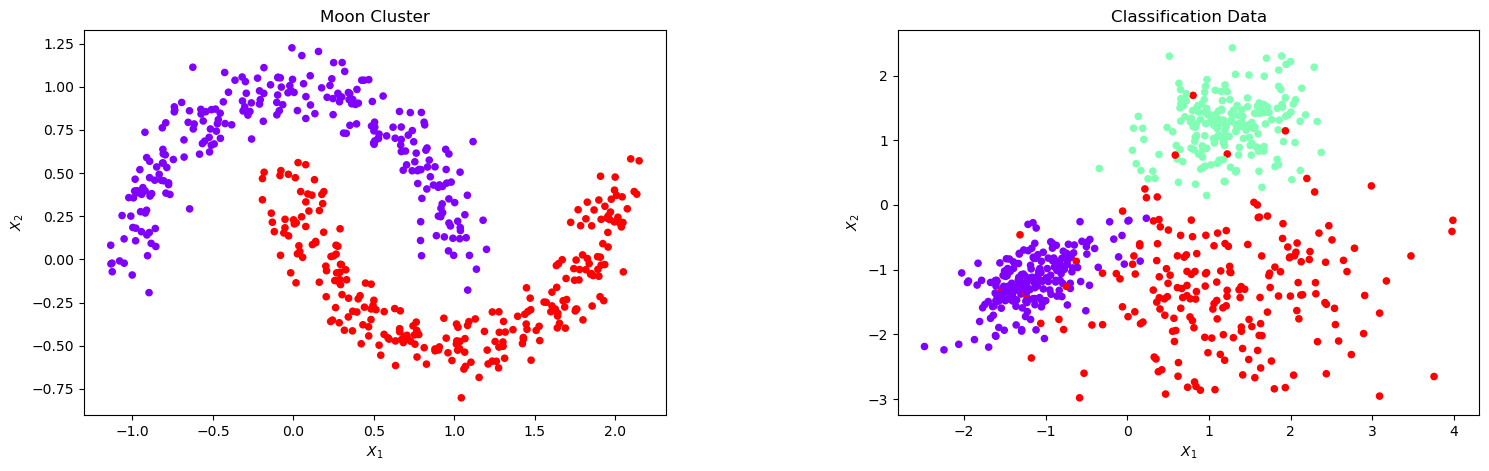

In [4]:
titles = ['Moon Cluster',
          'Classification Data',]
plt.figure(figsize=(18, 5)) 
for i, Xs in enumerate(([X_moon, y_moon], [X, y])):
    plt.subplot(1, 2, i+1)
    plt.subplots_adjust(wspace=0.4, hspace=0.1)
    
    plt.title(titles[i])
    plt.scatter(Xs[0][:,0], Xs[0][:,1], marker='o', c=Xs[1], s=20, cmap=plt.cm.rainbow)
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")

# Models

<img src=https://user-images.githubusercontent.com/35906602/204995098-86646f71-8d4c-46e1-a11d-014de8974acd.png width="1000">

이제 Stacking Ensemble의 학습을 위한 모델들을 학습시킵니다. 

Stacking Ensemble은 일반적으로 2개의 단계로 나뉩니다. 

* Base models : 다양한 모델을 학습하여 각 모델의 예측 결과를 구합니다. 이때 모델이 서로 다르고 데이터의 다양한 측면을 반영 할수록 최종 결과가 좋아집니다.
* Meta model : 위의 Base Model들의 예측 결과들을 다시 한번 meta 모델에 학습 시켜 최종 결과를 구합니다.  

## Moon Cluster

우선 위에서 생성한 Moon Cluster의 데이터를 사용해보겠습니다.

### Stage 1

우선 각 Base 모델들을 학습 시킵니다.

In [5]:
def Train_models(X,y):
    model_dict = dict()
    print('Training SVC (rbf)...')
    start = time.time()
    model_dict['SVC (kernel = rbf)'] = svm.SVC(kernel='rbf').fit(X, y)
    print(str(round(time.time() - start, 4)) + 's')
    print('Training SVC (poly)...')
    start = time.time()
    model_dict['SVC (kernel = poly)'] = svm.SVC(kernel='poly').fit(X, y)
    print(str(round(time.time() - start, 4)) + 's')
    print('Training Logistic Regression...')
    start = time.time()
    model_dict['Logistic Regression'] = LogisticRegression().fit(X, y)
    print(str(round(time.time() - start, 4)) + 's')
    print('Training Ridge...')
    start = time.time()
    model_dict['Ridge'] = RidgeClassifier().fit(X,y)
    print(str(round(time.time() - start, 4)) + 's')
    print('Training KNN...')
    start = time.time()
    model_dict['KNN'] = KNeighborsClassifier().fit(X, y)
    print(str(round(time.time() - start, 4)) + 's')
    print('Training Decision Tree...')
    start = time.time()
    model_dict['Decision Tree'] = DecisionTreeClassifier().fit(X, y)
    print(str(round(time.time() - start, 4)) + 's')
    print('Training Naive Bayes...')
    start = time.time()
    model_dict['Naive Bayes'] = GaussianNB().fit(X, y)
    print(str(round(time.time() - start, 4)) + 's')
    print('Training Random Forest...')
    start = time.time()
    model_dict['Random Forest'] = RandomForestClassifier().fit(X, y)
    print(str(round(time.time() - start, 4)) + 's')
    print('Training Gradient Boosting...')
    start = time.time()
    model_dict['Gradient Boost'] = GradientBoostingClassifier().fit(X=X, y=y)
    print(str(round(time.time() - start, 4)) + 's')
    print('Training LightGBM...')
    start = time.time()
    model_dict['LightGBM'] = LGBMClassifier().fit(X,y)
    print(str(round(time.time() - start, 4)) + 's')
    print('Training XGBoost...')
    start = time.time()
    model_dict['XGBoost'] = XGBClassifier(verbosity=0).fit(X,y)
    print(str(round(time.time() - start, 4)) + 's')
    print('Training CatBoost...')
    start = time.time()
    model_dict['CatBoost'] = CatBoostClassifier(silent=True).fit(X,y)
    print(str(round(time.time() - start, 4)) + 's')
    print('Done!')
    
    return model_dict

In [6]:
h = .01 
x_min, x_max = X_moon[:, 0].min() - 1, X_moon[:, 0].max() + 1
y_min, y_max = X_moon[:, 1].min() - 1, X_moon[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [7]:
models = Train_models(X_moon,y_moon)

Training SVC (rbf)...
0.003s
Training SVC (poly)...
0.0032s
Training Logistic Regression...
0.0052s
Training Ridge...
0.004s
Training KNN...
0.001s
Training Decision Tree...
0.0012s
Training Naive Bayes...
0.0013s
Training Random Forest...
0.141s
Training Gradient Boosting...
0.0831s
Training LightGBM...
0.215s
Training XGBoost...
0.1099s
Training CatBoost...
2.4636s
Done!


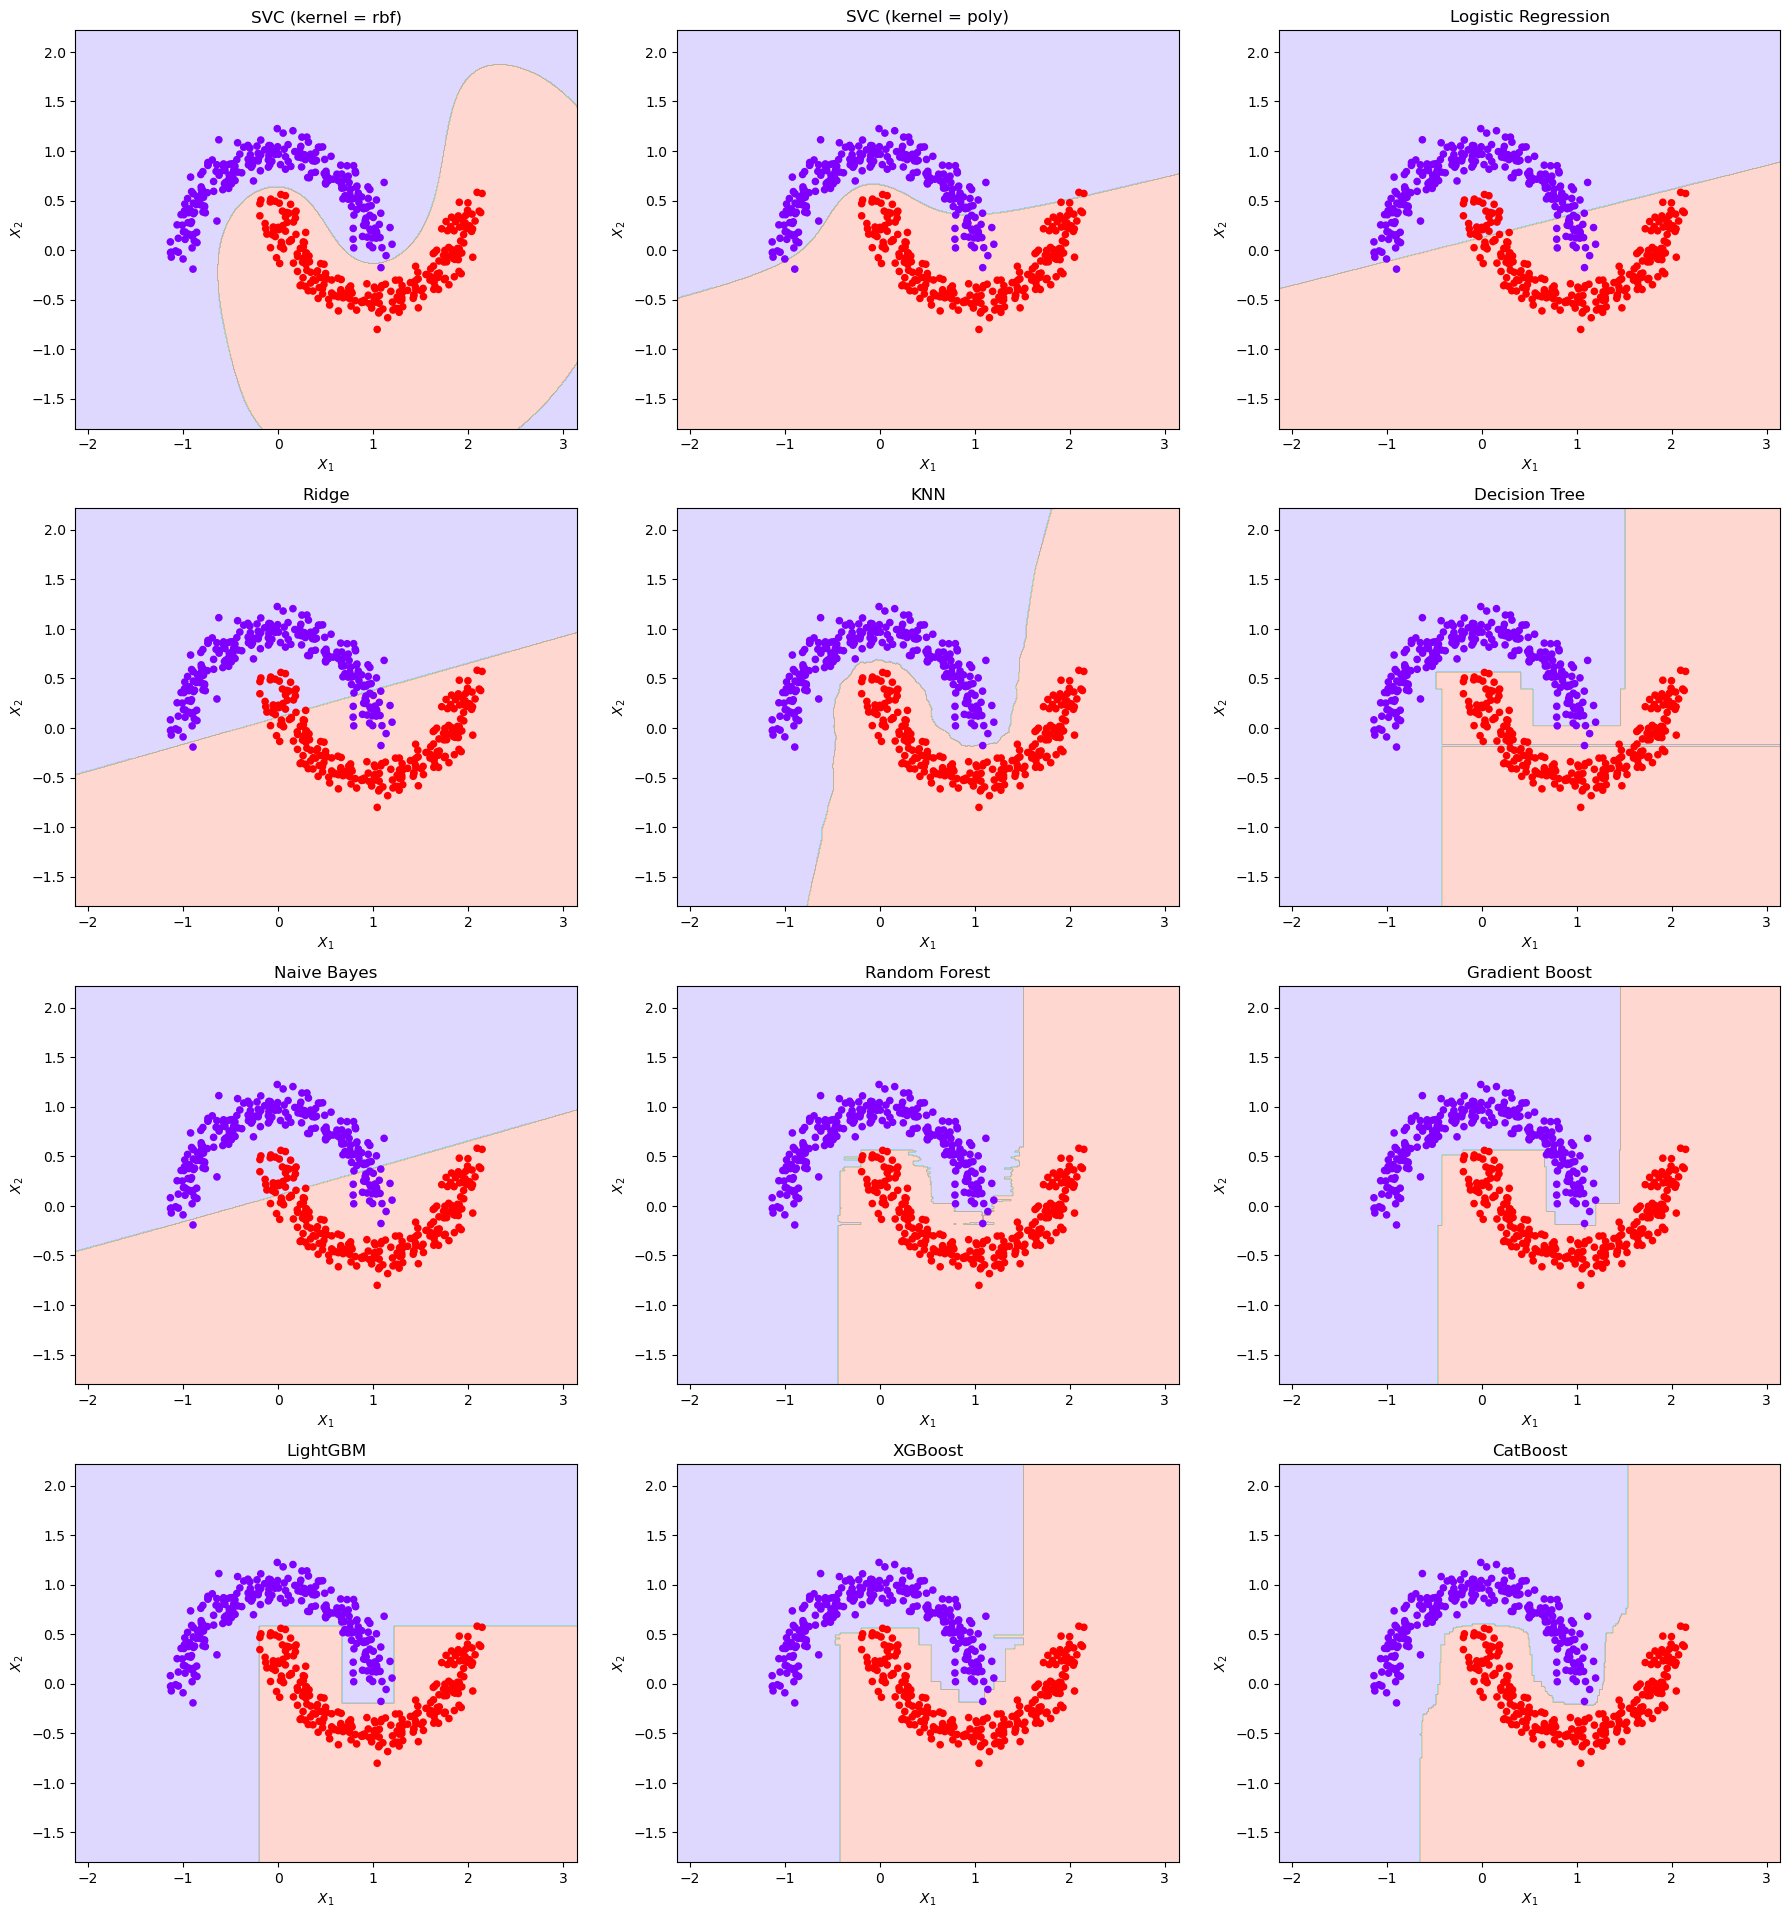

In [8]:
pred_label = pd.DataFrame()
pred_Z = pd.DataFrame()
plt.figure(figsize=(22, 30)) 

for i, model in enumerate(models):
    
    #plot 
    plt.subplot(5, 3, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    Z = models[model].predict(np.c_[xx.ravel(), yy.ravel()])
    pred_Z[model] = Z
    Z = Z.reshape(xx.shape)
    plt.title(f"{model}")
    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.2)
    plt.scatter(X_moon[:,0], X_moon[:,1], marker='o', c=y_moon, s=20, cmap=plt.cm.rainbow)
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")
    
    pred_label[model] = models[model].predict(X_moon)

각 모델이 그리는 결정 경계를 시각화 한 것입니다. 

앞에서 앙상블의 경우 각 모델이 서로 이질적일 경우 일반적으로 더 좋은 성능을 보인다고 하였는데, 비슷한 결정 경계를 그리는 모델도 있지만 서로 판이하게 다른 경우도 있기 때문에 좋은 효과를 거둘 것이라 기대할 수 있습니다.

### Stage2

이제 위에서 각 Base Model들이 예측한 결과를 Meta Model에 넣어 최종 결과를 보도록 하겠습니다. 

Meta Model로 복잡한 모델을 사용하게 될 경우 과적합의 위험이 크기 때문에 일반적으로 Logistic Regression과 같은 단순한 모델이 주로 사용됩니다.

여기서는 비교를 위해 단순하게 각 모델의 결과를 Majority Voting 한 결과와 단순한 모델인 Logistic Regression, 고차원으로 맵핑하는 SVC (rbf kernel), 비교적 복잡한 모델인 LightGBM을 각각 사용하여 결정 경계가 어떻게 나타나는지 살펴보겠습니다.

In [9]:
print('Training Logistic Regression...')
start = time.time()
stacking_lr = LogisticRegression().fit(pred_label, y_moon)
print(str(round(time.time() - start, 3)) + 's')
print('Training LightGBM...')
start = time.time()
stacking_lgbm = LGBMClassifier().fit(pred_label, y_moon)
print(str(round(time.time() - start, 3)) + 's')
print('Training SVC...')
start = time.time()
stacking_svm = svm.SVC().fit(pred_label, y_moon)
print(str(round(time.time() - start, 3)) + 's')
pred_Z['majority'] = pred_Z.mode(axis=1)[0]

Training Logistic Regression...
0.01s
Training LightGBM...
0.073s
Training SVC...
0.004s


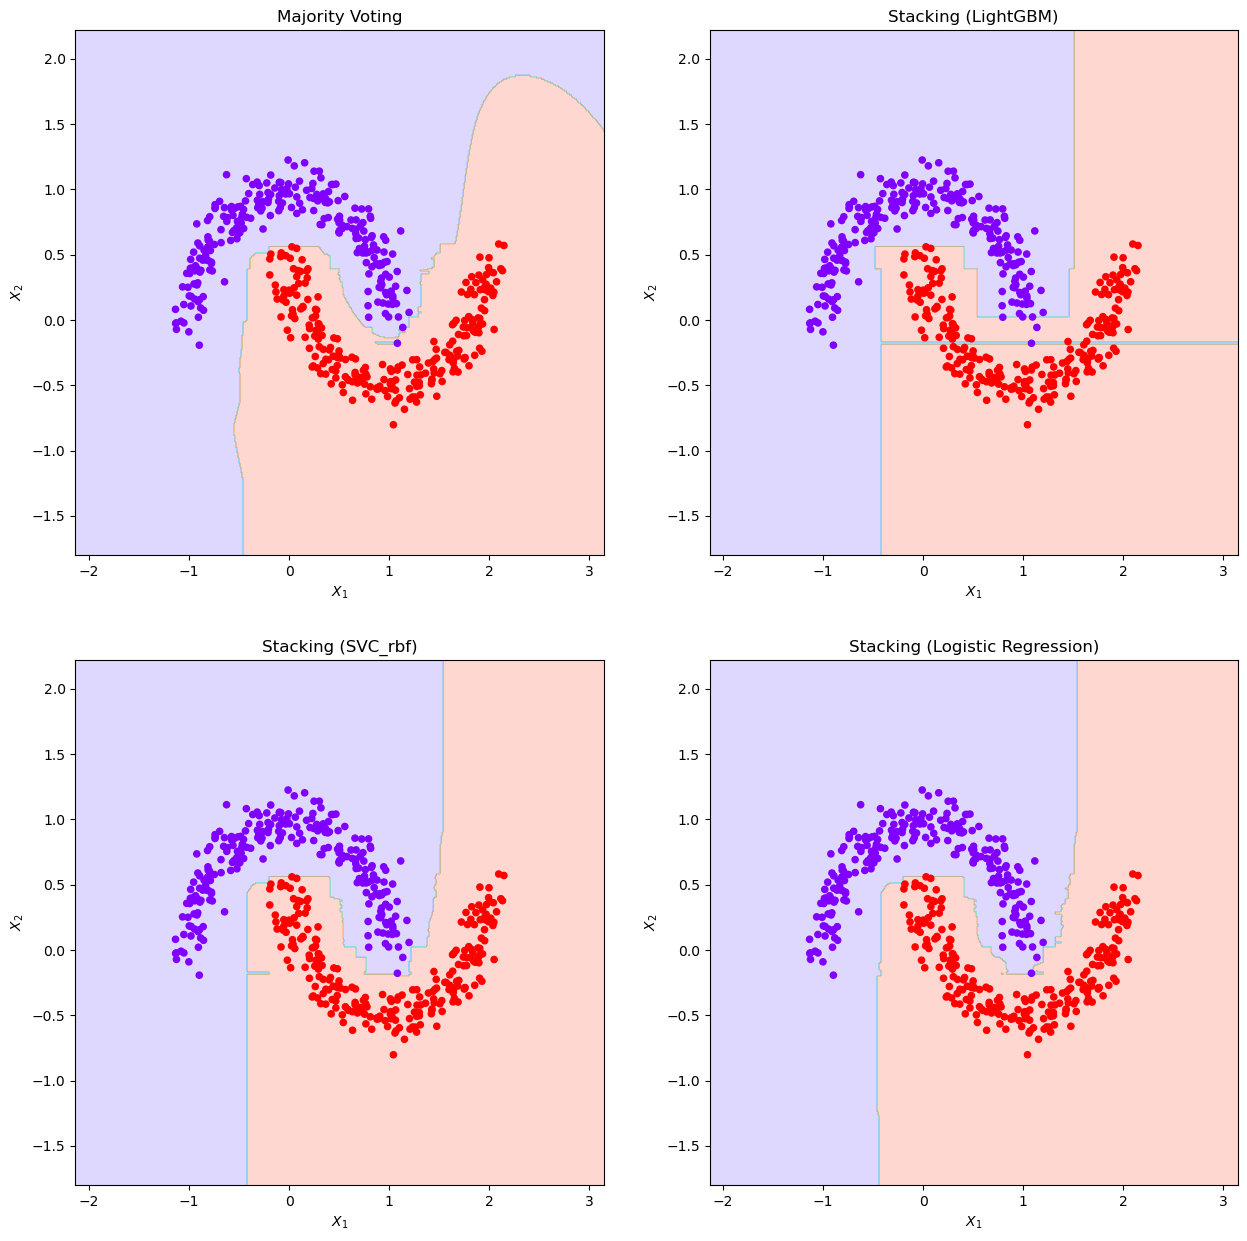

In [10]:
plt.figure(figsize=(15,15)) 

plt.subplot(2,2,1)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
Z = np.array(pred_Z['majority'])
Z = Z.reshape(xx.shape)
plt.title(f"Majority Voting")
plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.2)
plt.scatter(X_moon[:,0], X_moon[:,1], marker='o', c=y_moon, s=20, cmap=plt.cm.rainbow)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

plt.subplot(2,2,2)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
Z = stacking_lgbm.predict(pred_Z.iloc[:,:-1])
Z = Z.reshape(xx.shape)
plt.title(f"Stacking (LightGBM)")
plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.2)
plt.scatter(X_moon[:,0], X_moon[:,1], marker='o', c=y_moon, s=20, cmap=plt.cm.rainbow)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

plt.subplot(2,2,3)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
Z = stacking_svm.predict(pred_Z.iloc[:,:-1])
Z = Z.reshape(xx.shape)
plt.title(f"Stacking (SVC_rbf)")
plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.2)
plt.scatter(X_moon[:,0], X_moon[:,1], marker='o', c=y_moon, s=20, cmap=plt.cm.rainbow)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

plt.subplot(2,2,4)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
Z = stacking_lr.predict(pred_Z.iloc[:,:-1])
Z = Z.reshape(xx.shape)
plt.title(f"Stacking (Logistic Regression)")
plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.2)
plt.scatter(X_moon[:,0], X_moon[:,1], marker='o', c=y_moon, s=20, cmap=plt.cm.rainbow)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

plt.show()

Base Model들의 결과를 각 Meta Model로 학습 시킨 결과입니다. 전체적으로 하나의 Base Model을 사용 했을 때보다 더 합리적인 결정 경계를 나타내고 있습니다.

또한 앞서서 복잡한 모델을 사용할 경우 과적합의 위험이 있어 일반적으로는 비교적 단순한 모델을 사용한다고 하였습니다.

위 결과를 보면 LightGBM의 경우 빨간색의 영역에 보라색 영역 한 줄이 그어진 것을 확인 할 수 있습니다. Base Model들의 예측 결과에 과적합 되어 나타나는 현상으로, 이러한 현상 때문에 과적합이 발생한다는 것을 알 수 있스빈다.

SVC (rbf kernel) 혹은 Logistic Regression은 큰 차이를 보이지 않고 있으며, Majority Voting 역시 결정 경계가 불안정하긴 하지만 비슷한 결과를 나타내고 있습니다.

## Cluster Data

이번에는 위의 2개의 클래스를 분류하는 것이 아닌 3개의 클래스로 구성된 Cluster Data를 사용하여 시각화를 진행 해보겠습니다. 데이터를 제외한 다른 조건은 같습니다.

### Stage 1

In [11]:
h = .01 
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [12]:
models = Train_models(X,y)

Training SVC (rbf)...
0.0057s
Training SVC (poly)...
0.005s
Training Logistic Regression...
0.0159s
Training Ridge...
0.003s
Training KNN...
0.002s
Training Decision Tree...
0.0015s
Training Naive Bayes...
0.001s
Training Random Forest...
0.2233s
Training Gradient Boosting...
0.5329s
Training LightGBM...
3.2505s
Training XGBoost...
0.8733s
Training CatBoost...
3.5776s
Done!


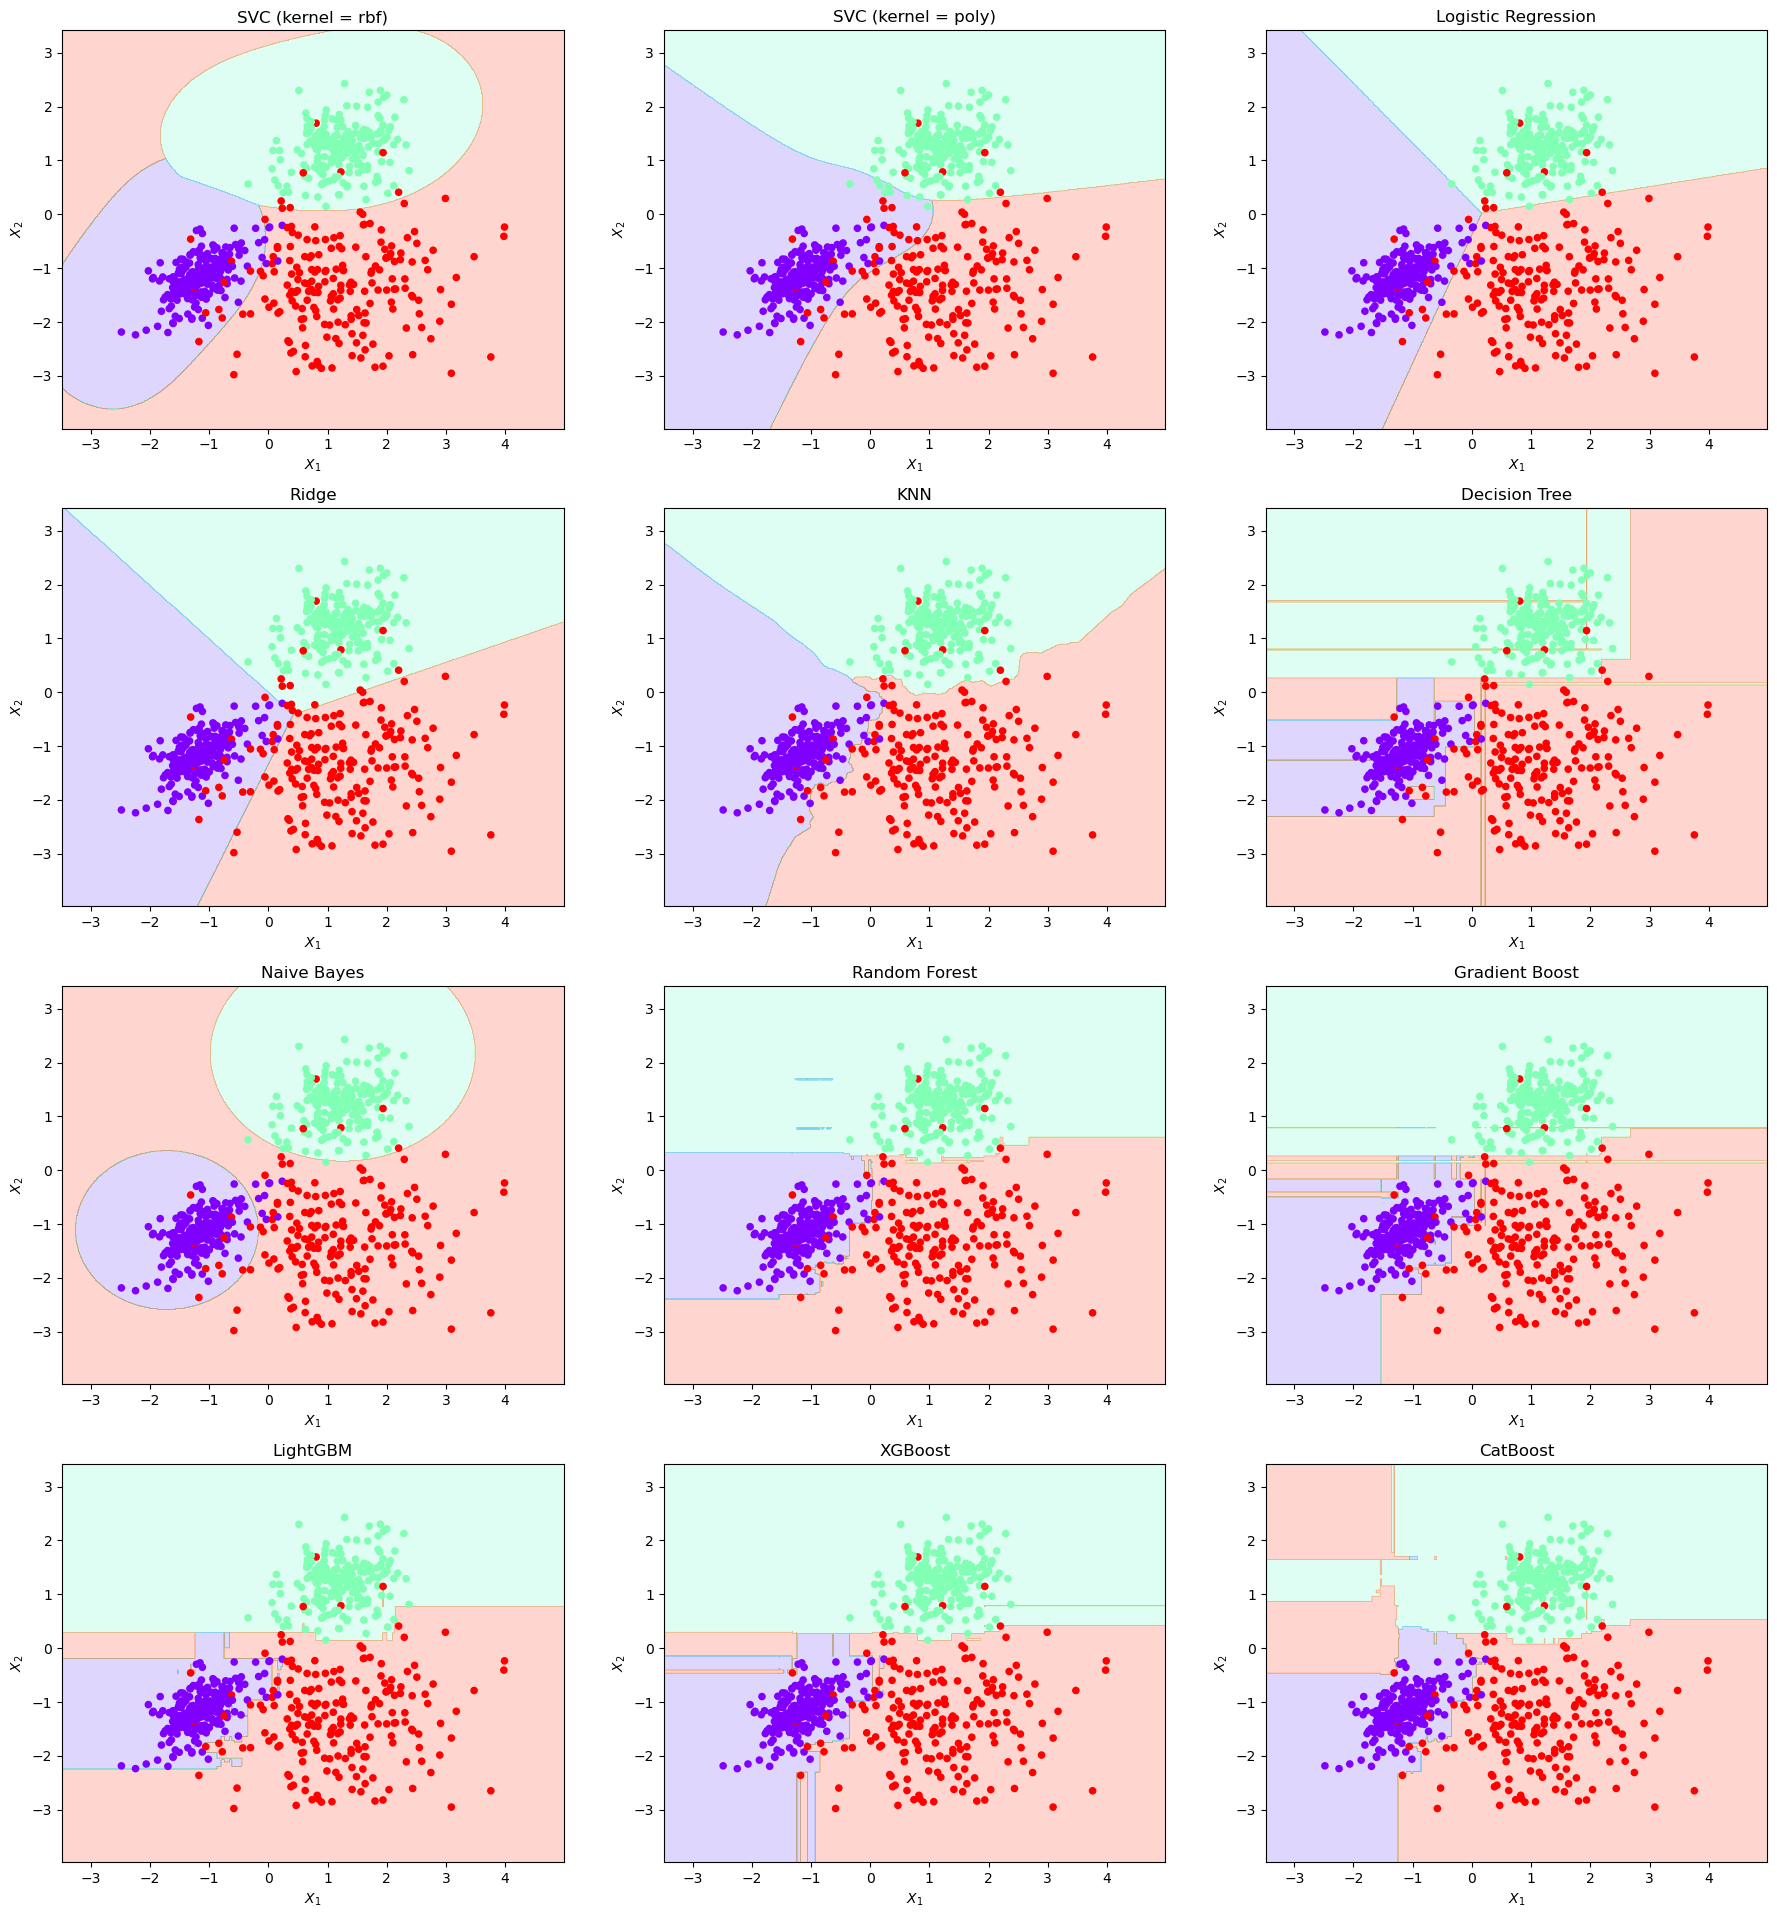

In [13]:
pred_label = pd.DataFrame()
pred_Z = pd.DataFrame()
plt.figure(figsize=(22, 30)) 

for i, model in enumerate(models):
    
    #plot 
    plt.subplot(5, 3, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    Z = models[model].predict(np.c_[xx.ravel(), yy.ravel()])
    pred_Z[model] = Z
    Z = Z.reshape(xx.shape)
    plt.title(f"{model}")
    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.2)
    plt.scatter(X[:,0], X[:,1], marker='o', c=y, s=20, cmap=plt.cm.rainbow)
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")
    
    pred_label[model] = models[model].predict(X)

위에서 Moon Cluster를 분류 하였을때 보다 더 모델별로 결정경계에 큰 차이를 보이고 있음을 알 수 있습니다. 

### Stage 2

마찬가지로 위에서 각각 학습된 Base Model들의 결과를 Meta Model에 넣어 시각화를 진행 해보겠습니다.

In [14]:
print('Training Logistic Regression...')
start = time.time()
stacking_lr = LogisticRegression().fit(pred_label, y)
print(str(round(time.time() - start, 3)) + 's')
print('Training LightGBM...')
start = time.time()
stacking_lgbm = LGBMClassifier().fit(pred_label, y)
print(str(round(time.time() - start, 3)) + 's')
print('Training SVC...')
start = time.time()
stacking_svm = svm.SVC().fit(pred_label, y)
print(str(round(time.time() - start, 3)) + 's')
pred_Z['majority'] = pred_Z.mode(axis=1)[0]

Training Logistic Regression...
0.029s
Training LightGBM...
0.553s
Training SVC...
0.006s


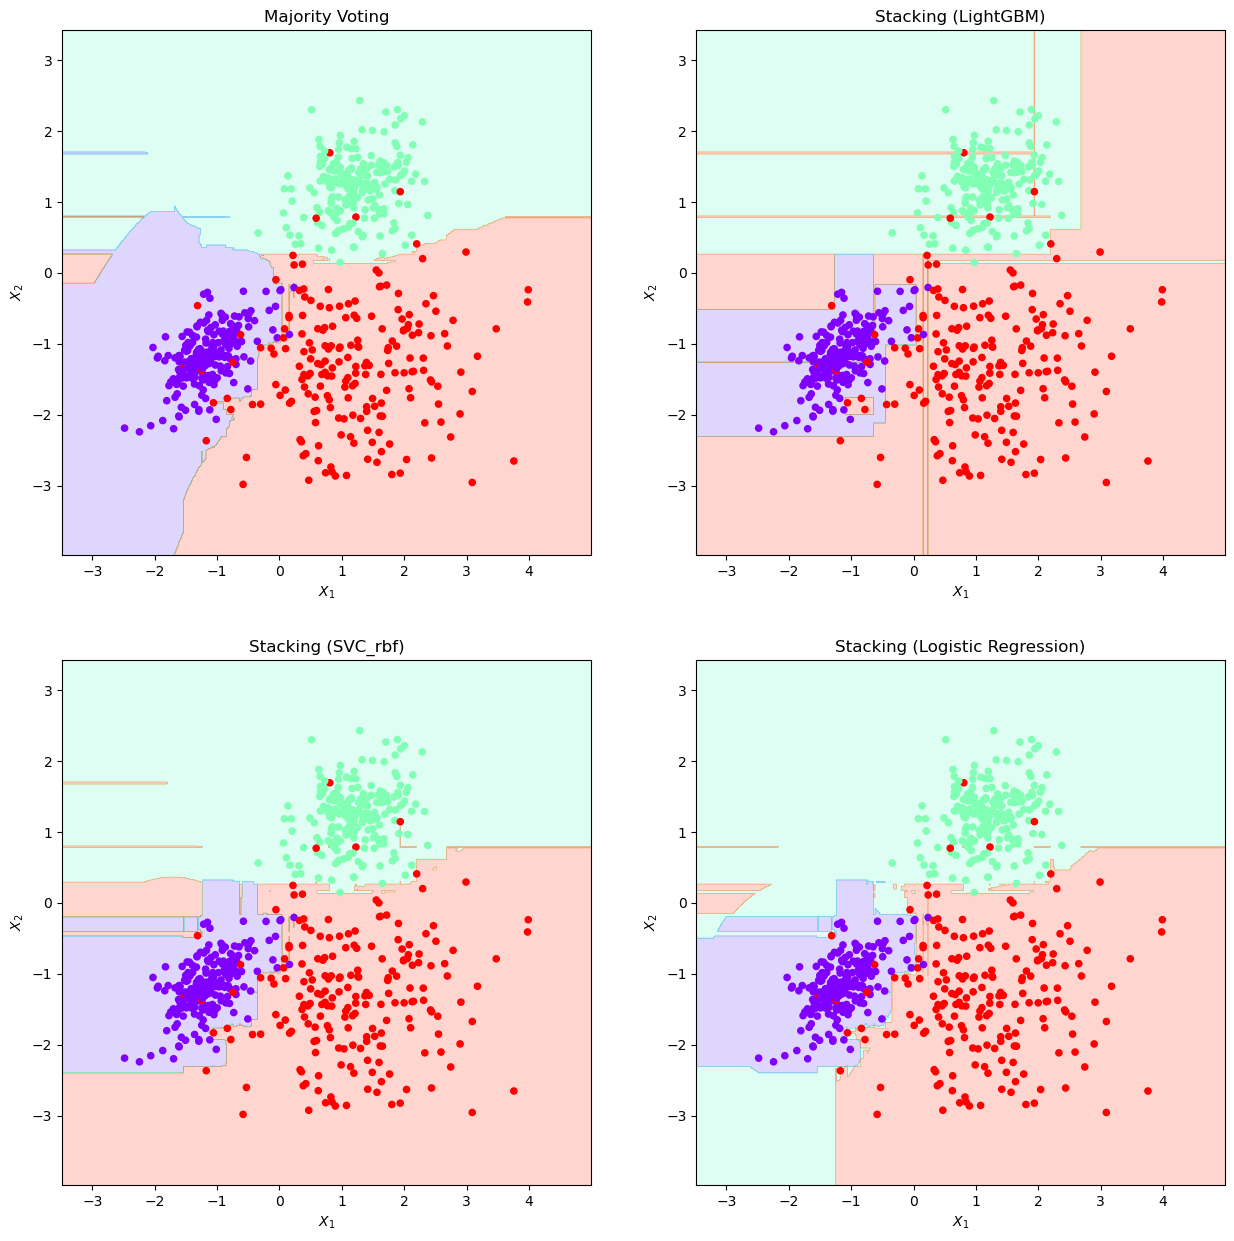

In [15]:
plt.figure(figsize=(15,15)) 

plt.subplot(2,2,1)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
Z = np.array(pred_Z['majority'])
Z = Z.reshape(xx.shape)
plt.title(f"Majority Voting")
plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.2)
plt.scatter(X[:,0], X[:,1], marker='o', c=y, s=20, cmap=plt.cm.rainbow)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

plt.subplot(2,2,2)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
Z = stacking_lgbm.predict(pred_Z.iloc[:,:-1])
Z = Z.reshape(xx.shape)
plt.title(f"Stacking (LightGBM)")
plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.2)
plt.scatter(X[:,0], X[:,1], marker='o', c=y, s=20, cmap=plt.cm.rainbow)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

plt.subplot(2,2,3)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
Z = stacking_svm.predict(pred_Z.iloc[:,:-1])
Z = Z.reshape(xx.shape)
plt.title(f"Stacking (SVC_rbf)")
plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.2)
plt.scatter(X[:,0], X[:,1], marker='o', c=y, s=20, cmap=plt.cm.rainbow)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

plt.subplot(2,2,4)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
Z = stacking_lr.predict(pred_Z.iloc[:,:-1])
Z = Z.reshape(xx.shape)
plt.title(f"Stacking (Logistic Regression)")
plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.2)
plt.scatter(X[:,0], X[:,1], marker='o', c=y, s=20, cmap=plt.cm.rainbow)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

plt.show()

Moon Cluster 데이터를 사용 했을 때와 마찬가지로 비교적 복잡한 모델인 LightGBM의 경우 중간중간에 과적합되어 합리적이지 않은 결정 경계를 그리고 있음을 확인 할 수 있습니다.

이번에는 오히려 Meta Model들을 통해 Stacking한 결과보다 Majority Voting한 결과가 더 합리적인 결정 경계를 그리고 있는 것처럼 보이기도 합니다.

# Real Dataset

이제는 고차원의 실제 데이터를 통해 결과를 살펴보도록 하겠습니다.

사용된 데이터 셋은 covertype 데이터셋입니다.(https://archive.ics.uci.edu/ml/datasets/covertype)

이 데이터는 미국 삼림을 30×30m 영역으로 나누어 각 영역의 특징으로부터 대표적인 나무의 종류(species of tree)을 예측하기 위한 데이터입니다. 7종류의 수종이 존재하며, Feature 공간의 차원은 54입니다. (https://datascienceschool.net/03%20machine%20learning/09.01%20%EB%B6%84%EB%A5%98%EC%9A%A9%20%EC%98%88%EC%A0%9C%20%EB%8D%B0%EC%9D%B4%ED%84%B0.html)



## Dataset

In [16]:
from sklearn.datasets import fetch_covtype

covtype = fetch_covtype()

df = pd.DataFrame(covtype.data, 
                  columns=["x{:02d}".format(i + 1) for i in range(covtype.data.shape[1])],
                  dtype=int)
sy = pd.Series(covtype.target, dtype="category")
df['covtype'] = sy
df.tail()

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,...,x46,x47,x48,x49,x50,x51,x52,x53,x54,covtype
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3
581011,2383,165,13,60,4,67,231,244,141,875,...,0,0,0,0,0,0,0,0,0,3


In [17]:
df['covtype'].value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: covtype, dtype: int64

각 클래스의 불균형이 심하고 데이터가 굉장히 많기 때문에 가장 데이터의 수가 적은 클래스인 4번 클래스를 기준으로 하여, 각 클래스에서 2,500개씩 데이터를 샘플링하여 진행하도록 하겠습니다.

In [18]:
new_df = pd.DataFrame()
for i in [1,2,3,4,5,6,7]:
    new_df = pd.concat([new_df, df[df['covtype'] == i].sample(2500, random_state=42)])

In [19]:
new_df['covtype'].value_counts()

1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
7    2500
Name: covtype, dtype: int64

In [20]:
y = new_df['covtype']
X = new_df.iloc[:,:-1]

In [21]:
# train test split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=42,stratify=new_df['covtype'])

각 클래스에서 2,500개씩 추출한 총 17,500개의 데이터를 다시 Train:Test=3:1 비율로 나누었습니다.

In [22]:
train_X.reset_index(drop = True, inplace = True)
test_X.reset_index(drop = True, inplace = True)
train_y.reset_index(drop = True, inplace = True)
test_y.reset_index(drop = True, inplace = True)

## Stacking Ensemble

이제 위와 마찬가지로 Base Model들을 학습해보도록 하겠습니다. 위와 같은 Base Model들을 사용하였으며, 하이퍼 파라미터는 각 모델의 library에서 주어지는 기본 값으로 진행해보도록 하겠습니다.

### Stage 1

In [23]:
models = Train_models(train_X, train_y)

Training SVC (rbf)...
24.3951s
Training SVC (poly)...
17.3296s
Training Logistic Regression...
0.7157s
Training Ridge...
0.0378s
Training KNN...
0.006s
Training Decision Tree...
0.1658s
Training Naive Bayes...
0.0289s
Training Random Forest...
3.1137s
Training Gradient Boosting...
26.284s
Training LightGBM...
9.0089s
Training XGBoost...
8.6329s
Training CatBoost...
20.0247s
Done!


In [24]:
pred_label = pd.DataFrame()
for i, model in enumerate(models):
    pred_label[model] = models[model].predict(test_X)

In [25]:
results = pd.DataFrame(columns = ['model', 'Accuracy'])
for model in pred_label.columns:
    score = accuracy_score(test_y, pred_label[model])
    result = [f'Base_{model}', score]
    results.loc[len(results)] = result

In [26]:
results.sort_values('Accuracy', ascending=False)

,model,Accuracy
7,Base_Random Forest,0.872229
11,Base_CatBoost,0.864000
9,Base_LightGBM,0.863771
10,Base_XGBoost,0.863543
4,Base_KNN,0.812343
8,Base_Gradient Boost,0.797714
5,Base_Decision Tree,0.784914
3,Base_Ridge,0.635429
0,Base_SVC (kernel = rbf),0.625371
1,Base_SVC (kernel = poly),0.615543


위 결과는 각 Base Model들을 훈련 데이터로 학습시킨 후 테스트 데이터에서 성능을 살펴 본 결과입니다. 

개별 모델과 Stacking Ensemble을 진행한 최종 결과가 어떻게 달라지는지 뒤에서 살펴보도록 하겠습니다.

In [27]:
top_50 = results.sort_values('Accuracy', ascending=False).iloc[:int(len(results.model)/2)].model

이때 앙상블에서 학습한 모든 모델을 사용 할 수도 있지만, 비교적 좋은 성능을 보인 일부 모델만 사용 할 수도 있을 것 같습니다.

일반적으로는 일정 이상의 성능만 보인다면 최대한 많은 모델을 사용하는 것이 일반화 성능을 높이기 때문에 더 좋은 성능을 기대할 수 있다고 알려져 있습니다.

이 모델들과 데이터에서도 정말 그런 결과가 나타나는지 확인해보기 위해 개별 모델의 성능을 기준으로 상위 50%의 모델만 사용하여 따로 학습해 모든 모델을 사용 한 결과와 비교해보도록 하겠습니다.

In [28]:
pred_label

,SVC (kernel = rbf),SVC (kernel = poly),Logistic Regression,Ridge,KNN,Decision Tree,Naive Bayes,Random Forest,Gradient Boost,LightGBM,XGBoost,CatBoost
0,5,5,5,5,5,5,5,5,5,5,5,5
1,3,3,6,6,3,3,3,3,3,3,3,3
2,5,5,3,3,3,3,3,3,3,3,3,3
3,6,6,4,3,6,3,3,6,6,6,6,6
4,7,7,1,1,7,1,1,7,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4370,1,1,1,1,2,1,1,2,2,2,1,1
4371,7,7,7,7,7,7,7,7,7,7,7,7
4372,7,7,1,1,7,7,1,7,7,7,7,7
4373,2,2,1,1,5,5,1,5,5,5,5,5


위처럼 각 모델에서 예측한 라벨들이 Meta Model의 입력 데이터로 사용됩니다.

### Stage 2

In [29]:
stage1 = pd.DataFrame()
for i, model in enumerate(models):
    stage1[model] = models[model].predict(train_X)

#### All Base Models

여기서는 모든 Base Model들을 사용하여 Train Data의 학습 및 Test Data의 예측을 진행해보도록 하겠습니다.

In [ ]:
print('Training Logistic Regression...')
start = time.time()
stacking_lr = LogisticRegression().fit(stage1, train_y)
print(str(round(time.time() - start, 3)) + 's')
print('Training LightGBM...')
start = time.time()
stacking_lgbm = LGBMClassifier().fit(stage1, train_y)
print(str(round(time.time() - start, 3)) + 's')
print('Training SVC...')
start = time.time()
stacking_svm = svm.SVC().fit(stage1, train_y)
print(str(round(time.time() - start, 3)) + 's')
majority = pred_label.mode(axis=1)[0]

Training Logistic Regression...
0.76s
Training LightGBM...
5.887s
Training SVC...
0.612s


In [31]:
results.loc[len(results)] = ['Meta(all)_Logistic Regression', accuracy_score(test_y, stacking_lr.predict(pred_label))]
results.loc[len(results)] = ['Meta(all)_LightGBM', accuracy_score(test_y, stacking_lgbm.predict(pred_label))]
results.loc[len(results)] = ['Meta(all)_SVC', accuracy_score(test_y, stacking_svm.predict(pred_label))]
results.loc[len(results)] = ['Majority Vote (all)', accuracy_score(test_y, majority)]

결과는 뒤에서 살펴보겠습니다.

#### Top 50% Base Models

이제 모든 Base Model들이 아닌, 개별 모델의 성능을 기준으로 상위 50%의 모델들만 선택하여 Meta Model에 학습 시켜보도록 하겠습니다.

In [32]:
stage1_top50 = stage1.iloc[:,top_50.index]
pred_label_top50 = pred_label.iloc[:, top_50.index]

In [33]:
print('Training Logistic Regression...')
start = time.time()
stacking_lr = LogisticRegression().fit(stage1_top50, train_y)
print(str(round(time.time() - start, 3)) + 's')
print('Training LightGBM...')
start = time.time()
stacking_lgbm = LGBMClassifier().fit(stage1_top50, train_y)
print(str(round(time.time() - start, 3)) + 's')
print('Training SVC...')
start = time.time()
stacking_svm = svm.SVC().fit(stage1_top50, train_y)
print(str(round(time.time() - start, 3)) + 's')
majority = pred_label_top50.mode(axis=1)[0]

Training Logistic Regression...
0.659s
Training LightGBM...
6.233s
Training SVC...
0.243s


In [34]:
results.loc[len(results)] = ['Meta(top50)_Logistic Regression', accuracy_score(test_y, stacking_lr.predict(pred_label_top50))]
results.loc[len(results)] = ['Meta(top50)_LightGBM', accuracy_score(test_y, stacking_lgbm.predict(pred_label_top50))]
results.loc[len(results)] = ['Meta(top50)_SVC', accuracy_score(test_y, stacking_svm.predict(pred_label_top50))]
results.loc[len(results)] = ['Majority Vote (top50)', accuracy_score(test_y, majority)]

In [35]:
results.sort_values('Accuracy', ascending=False)

,model,Accuracy
19,Majority Vote (top50),0.873143
7,Base_Random Forest,0.872229
17,Meta(top50)_LightGBM,0.872229
18,Meta(top50)_SVC,0.866286
11,Base_CatBoost,0.864000
9,Base_LightGBM,0.863771
10,Base_XGBoost,0.863543
15,Majority Vote (all),0.854629
16,Meta(top50)_Logistic Regression,0.826286
4,Base_KNN,0.812343


최종 결과입니다. 예상과는 다르게, Meta Model을 통해 Stacking Ensemble을 한 것이 아닌 상위 50%의 Base Model들의 결과를 Majority Voting 한 결과가 가장 높은 성능을 보이고 있습니다.

그 다음으로는 Base Model인 Random Forest가 좋은 성능을 보였습니다.

하나의 데이터를 대상으로 한 번의 실험만 진행한 결과이기 때문에 일반화 할 수는 없지만, Stacking Ensemble을 하는게 더 낮은 성능을 보여줄 수도 있다는 점을 확인 할 수 있습니다.

이때 앞에서 사용한 Stacking Ensemble 방법은 사실은 잘 사용되지는 않는 방법입니다. 일반적으로는, CV 방식의 Stacking Ensemble을 사용하게 됩니다.

## CV Stacking Ensemble

![image](https://user-images.githubusercontent.com/35906602/204994405-9c3c0f64-6dd4-4d00-8c8b-1e8adcbdadfa.png)  
출처 : https://www.inflearn.com/course/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C#  
(인프런의 권민철 강사님의 '파이썬 머신러닝 완벽 가이드')

실제로 활용되는 방법인 CV Stacking Ensemble 방법입니다.

이렇게 CV를 활용할 경우 모델의 갯수를 늘려 더 좋은 앙상블의 효과를 기대할 수 있습니다. 가령 K-Fold CV에서 K=5로 둘 경우, 하나의 모델이 아닌 각각 다른 데이터로 학습시킨 5개의 모델이 학습되게 됩니다.

이러한 방법을 통해 더 높은 일반화 성능을 기대할 수 있습니다.

### Stage 1

In [36]:
from sklearn.model_selection import KFold

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

여기서는 K=5로 둔 K-Fold CV 방법을 활용해 Stacking Ensemble을 진행하겠습니다.

In [38]:
KFold_models = dict()
for i, data in enumerate(kf.split(train_X)):
    print(f'---------------- {i+1} Fold ----------------')
    KFold_models[i] = Train_models(train_X.iloc[data[0]], train_y.iloc[data[0]])
    print(' ')

---------------- 1 Fold ----------------
Training SVC (rbf)...
15.6076s
Training SVC (poly)...
10.8236s
Training Logistic Regression...
0.5795s
Training Ridge...
0.0339s
Training KNN...
0.006s
Training Decision Tree...
0.1284s
Training Naive Bayes...
0.0217s
Training Random Forest...
2.2942s
Training Gradient Boosting...
20.1783s
Training LightGBM...
9.014s
Training XGBoost...
7.5856s
Training CatBoost...
18.8733s
Done!
 
---------------- 2 Fold ----------------
Training SVC (rbf)...
15.8169s
Training SVC (poly)...
11.3664s
Training Logistic Regression...
0.5789s
Training Ridge...
0.0332s
Training KNN...
0.0067s
Training Decision Tree...
0.1296s
Training Naive Bayes...
0.019s
Training Random Forest...
2.2508s
Training Gradient Boosting...
19.8976s
Training LightGBM...
8.9015s
Training XGBoost...
7.5377s
Training CatBoost...
18.8359s
Done!
 
---------------- 3 Fold ----------------
Training SVC (rbf)...
15.7137s
Training SVC (poly)...
11.1512s
Training Logistic Regression...
0.5685s
Tra

위에서 각 Fold마다 학습시킨 모델을 활용해, 학습 데이터로 선택되지 않은 나머지 데이터를 예측하게 됩니다. 이 결과를 모두 종합하여 최종 Meta Model의 Input으로 활용합니다. 

In [39]:
stage1_train_all = pd.DataFrame()
indices = []
for k, data in enumerate(kf.split(train_y)):
    stage1_train = pd.DataFrame()
    indices += list(data[1])
    for i, model in enumerate(KFold_models[k]):
        stage1_train[model] = KFold_models[k][model].predict(train_X.iloc[data[1]])
    stage1_train_all = pd.concat([stage1_train_all, stage1_train], axis=0)

* stage1_train_all : 나중에 stage 2에서 Train Data로 사용 (y = train_y[indices])

In [40]:
models = dict()
for model in KFold_models[0]:
    models[model] = []
    for k in KFold_models:
        models[model].append(KFold_models[k][model].predict(test_X))
models['CatBoost'] = np.array(models['CatBoost']).reshape(np.shape(models['KNN']))

In [41]:
pred_labels = pd.DataFrame()
for model in models:
    pred_labels[model] = pd.DataFrame(np.array(models[model]).T).mode(axis=1)[0]

이때 Test Data의 경우에는 각 모델별로 각각의 Fold마다 학습했던 모델을 사용해 예측 결과를 구하고, 다수결로 각 모델마다 답을 정하게 됩니다.

가령 5개의 Random Forest 모델에서 하나의 테스트 데이터의 인스턴스에 대해 4개는 4, 3개는 3이라고 예측했다면 Random Forest는 최종적으로 4를 답으로 선택합니다.

In [42]:
pred_labels

,SVC (kernel = rbf),SVC (kernel = poly),Logistic Regression,Ridge,KNN,Decision Tree,Naive Bayes,Random Forest,Gradient Boost,LightGBM,XGBoost,CatBoost
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,3.0,3.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,6.0,6.0,4.0,3.0,6.0,6.0,3.0,6.0,6.0,6.0,6.0,6.0
4,7.0,7.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4370,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0
4371,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
4372,7.0,7.0,1.0,1.0,7.0,7.0,1.0,7.0,7.0,7.0,7.0,7.0
4373,1.0,2.0,2.0,1.0,5.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0


* pred_labels : Test Data를 stage 1의 각 KFold 모델들로 예측하여 최빈값을 최종 결과로 한 것으로, Stage 2에서 Test Data의 예측에 사용됨

### Stage 2

이제 위에서 준비된 데이터들을 활용해 Meta Model을 학습시키도록 하겠습니다. Meta Model을 학습시키는 단계는 위에서 구성된 Input Data를 사용한다는 것만 다르고, 나머지는 같습니다.

#### All Base Models

In [43]:
print('Training Logistic Regression...')
start = time.time()
stacking_lr = LogisticRegression().fit(stage1_train_all, train_y[indices])
print(str(round(time.time() - start, 3)) + 's')
print('Training LightGBM...')
start = time.time()
stacking_lgbm = LGBMClassifier().fit(stage1_train_all, train_y[indices])
print(str(round(time.time() - start, 3)) + 's')
print('Training SVC...')
start = time.time()
stacking_svm = svm.SVC().fit(stage1_train_all, train_y[indices])
print(str(round(time.time() - start, 3)) + 's')
majority = pred_labels.mode(axis=1)[0]

Training Logistic Regression...
0.531s
Training LightGBM...
9.157s
Training SVC...
2.561s


In [44]:
results.loc[len(results)] = ['Meta_CV(all)_Logistic Regression', accuracy_score(test_y, stacking_lr.predict(pred_labels))]
results.loc[len(results)] = ['Meta_CV(all)_LightGBM', accuracy_score(test_y, stacking_lgbm.predict(pred_labels))]
results.loc[len(results)] = ['Meta_CV(all)_SVC', accuracy_score(test_y, stacking_svm.predict(pred_labels))]
results.loc[len(results)] = ['Majority Vote_CV(all)', accuracy_score(test_y, majority)]

#### Top 50% Base Models

이 경우에도 마찬가지로 성능 기준 상위 50%의 모델만 사용한 결과를 이용해보도록 하겠습니다.

In [45]:
stage1_train_all_top50 = stage1_train_all.iloc[:,top_50.index]
pred_labels_top50 = pred_labels.iloc[:, top_50.index]

In [46]:
print('Training Logistic Regression...')
start = time.time()
stacking_lr = LogisticRegression().fit(stage1_train_all_top50, train_y[indices])
print(str(round(time.time() - start, 3)) + 's')
print('Training LightGBM...')
start = time.time()
stacking_lgbm = LGBMClassifier().fit(stage1_train_all_top50, train_y[indices])
print(str(round(time.time() - start, 3)) + 's')
print('Training SVC...')
start = time.time()
stacking_svm = svm.SVC().fit(stage1_train_all_top50, train_y[indices])
print(str(round(time.time() - start, 3)) + 's')
majority = pred_labels_top50.mode(axis=1)[0]

Training Logistic Regression...
0.456s
Training LightGBM...
9.302s
Training SVC...
1.974s


In [47]:
results.loc[len(results)] = ['Meta_CV(top50)_Logistic Regression', accuracy_score(test_y, stacking_lr.predict(pred_labels_top50))]
results.loc[len(results)] = ['Meta_CV(top50)_LightGBM', accuracy_score(test_y, stacking_lgbm.predict(pred_labels_top50))]
results.loc[len(results)] = ['Meta_CV(top50)_SVC', accuracy_score(test_y, stacking_svm.predict(pred_labels_top50))]
results.loc[len(results)] = ['Majority Vote_CV(top50)', accuracy_score(test_y, majority)]

In [48]:
results.sort_values('Accuracy', ascending=False)

,model,Accuracy
21,Meta_CV(all)_LightGBM,0.874286
19,Majority Vote (top50),0.873143
7,Base_Random Forest,0.872229
17,Meta(top50)_LightGBM,0.872229
22,Meta_CV(all)_SVC,0.870171
25,Meta_CV(top50)_LightGBM,0.869714
27,Majority Vote_CV(top50),0.868800
26,Meta_CV(top50)_SVC,0.866743
18,Meta(top50)_SVC,0.866286
11,Base_CatBoost,0.864000


최종 결과입니다.

앞서서 Meta Model로 복잡한 모델을 사용 할 경우에는 과적합의 위험이 있어 단순한 모델을 주로 사용한다고 하였는데, 다른 결과가 나타났습니다.

최종적으로는 CV를 활용한 Stacking Ensemble에서, Meta Model을 LightGBM으로 사용한 경우가 가장 좋은 결과를 보여주고 있습니다.

해당 방법의 CV를 사용하지 않았을 경우의 Accuracy는 약 0.78로 무려 성능이 0.09나 상승했습니다.  

다른 Meta Model 및 Base Model을 사용한 경우에도 대체로 CV를 한 경우가 하지 않은 경우보다 더 좋은 성능을 보여주고 있습니다.

하지만 2등은 여전히 상위 50%의 모델만 사용한 결과의 Majority Vote였습니다.

물론 하나의 데이터에 대해 한번의 실험만 진행한 결과이기 때문에 일반화 하기에는 무리가 있지만, Stacking Ensemble을 활용하고자 할 경우에는 꼭 CV 방식을 사용하는 것이 좋다는 점을 알 수 있습니다. 

## 결론

* Stacking Ensemble을 사용 할 경우에는 CV 방식을 적용한 Stacking Ensemble을 하는 것이 좋다.
* 일반적으로 Meta Model의 경우 과적합을 방지하기 위해 Logistic Regression과 같은 단순한 모델을 사용하는 것이 좋다고 알려져 있지만, 항상 그렇지는 않을 수 있다.
* Base Model들의 결과를 단순히 Majority Vote하는 것도 고려 할 수 있다.
* 지나치게 낮은 성능을 보이는 Base Model은 배제하는 것이 최종 결과에 더 나을 수 있다.